In [6]:
import sys
import io
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import graphviz
import nni

import torch
import torch.nn as nn
from nni.nas.evaluator import FunctionalEvaluator
from nni.nas.experiment import NasExperiment
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.utils.data import Subset

sys.path.insert(0, '/pbabkin/nas-for-moe/code')
import nas_moe.utils
import nas_moe.dataset
import nas_moe.moe_arch
import nas_moe.single_arch
import nas_moe.nni_utils

SEED = 322
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
dataset_name = 'mnist'
NUM_WORKERS = 4
WIDTH = 8
BATCH_SIZE = 64
NUM_CELLS = 3

In [8]:
if dataset_name == 'mnist':
    h, w = 28, 28
INPUT_LENGTH = h * w

permutation = torch.randperm(INPUT_LENGTH)
reverse_permutation = torch.argsort(permutation)

# Dataset

In [9]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,))
])
data_path = '/pbabkin/nas-for-moe/code/data'

In [10]:
if dataset_name == 'mnist':
    train_dataset = nas_moe.dataset.DistortedMNIST(
        root=data_path,
        train=True,
        download=True,
        custom_transform=transform,
        distortions=['permutation'],
        permutation=reverse_permutation
    )
    train_dataset = Subset(train_dataset, range(60000, 120000))

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=True  # ускоряет передачу на GPU
)

In [11]:
test_dataset = nas_moe.dataset.DistortedMNIST(
    root=data_path,
    train=False,
    download=True,
    custom_transform=transform,
    distortions=['permutation'],
    permutation=reverse_permutation
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=1, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True
)

# Cluster

In [12]:
k = 2

data = []
for i in range(len(train_dataset)):
    x, _ = train_dataset[i]  # Получаем изображение и метку
    data.append(x.numpy().reshape(-1))  # Разворачиваем в вектор
X_train = np.stack(data)
kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans.fit(X_train)
cluster_labels_train = kmeans.labels_

data = []
for i in range(len(test_dataset)):
    x, _ = test_dataset[i]  # Получаем изображение и метку
    data.append(x.numpy().reshape(-1))  # Разворачиваем в вектор
X_test = np.stack(data)
kmeans = KMeans(n_clusters=k, random_state=SEED)
kmeans.fit(X_test)
cluster_labels_test = kmeans.labels_

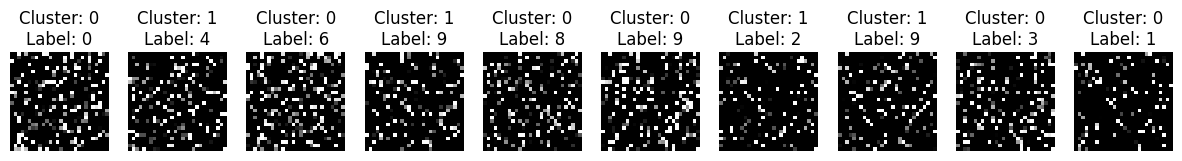

In [13]:
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(train_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = train_dataset[idx]
    cluster_label = cluster_labels_train[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}')
    plt.axis('off')
plt.show()

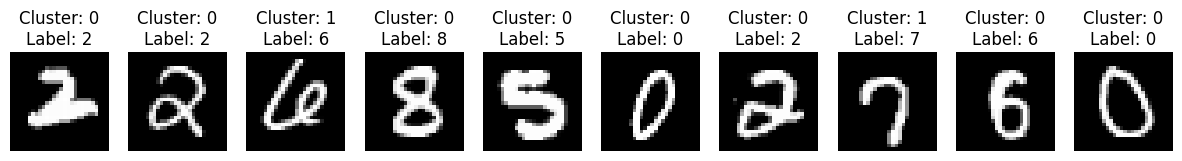

In [14]:
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(train_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = train_dataset[idx]
    image = permut(image[np.newaxis, :])
    cluster_label = cluster_labels_train[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}')
    plt.axis('off')
plt.show()

# Architectural space

In [16]:
NUM_NODES = 5

In [17]:
model_space = nas_moe.nni_utils.PixelPermutationSpace(
    width=WIDTH,
    num_cells=NUM_CELLS,
    dataset=dataset_name,
    permutation=reverse_permutation,
    num_nodes_per_cell=NUM_NODES
)
arch_dicts = []

# Get archs

In [58]:
# Add normal archs
archGenerator = nas_moe.single_arch.ArchitectureGenerator(model_space, NUM_NODES+1, SEED)
K = 2
arch_dicts += [archGenerator.generate_arch()['architecture'] for _ in range(K)]

In [18]:
# Add archs w/o permutation
archGenerator_no_permut = nas_moe.single_arch.ArchitectureGenerator(model_space, NUM_NODES+1, SEED, remove_permutation=True)
K = 2
arch_dicts += [archGenerator_no_permut.generate_arch()['architecture'] for _ in range(K)]

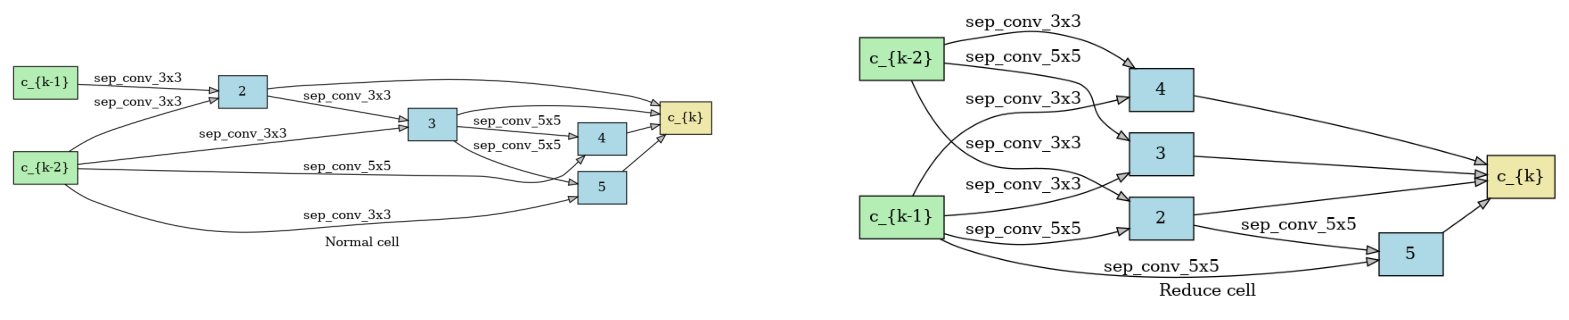

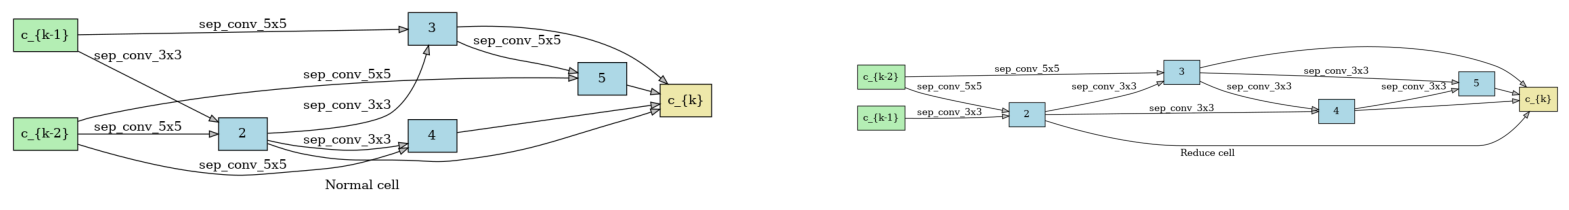

In [19]:
# Archs in MoE
for d in arch_dicts:
    nas_moe.utils.plot_double_cells(d)

# MoE

In [205]:
moe = nas_moe.moe_arch.MoE(arch_dicts,
                           nas_moe.nni_utils.PixelPermutationSpace,
                           INPUT_LENGTH,
                           width=WIDTH,
                           num_cells=model_space.num_cells,
                           permutation=permutation,
                           dataset=dataset_name)

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(moe.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
moe.to(device)
num_epochs = 2

In [101]:
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')
    
    moe.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = moe(images)
        loss = criterion(outputs, labels)
        # lb_loss = moe.compute_load_balancing_loss(images)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f'Train  Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:39<00:00, 47.98it/s]


Train  Loss: 0.3394, Accuracy: 0.8916
Epoch 2/2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:38<00:00, 48.64it/s]

Train  Loss: 0.1793, Accuracy: 0.9447


# One model

In [206]:
from nni.nas.space import model_context
with model_context(arch_dicts[1]):
    expert = nas_moe.nni_utils.PixelPermutationSpace(
        width=WIDTH,
        num_cells=NUM_CELLS,
        dataset=dataset_name,
        permutation=permutation
    )
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
optimizer = optim.Adam(expert.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
expert.to(device)
expert.train()
num_epochs = 2

In [207]:
for epoch in range(1, num_epochs + 1):
    print(f'Epoch {epoch}/{num_epochs}')

    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = expert(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    print(f'Train  Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch 1/2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 116.64it/s]


Train  Loss: 0.3622, Accuracy: 0.8841
Epoch 2/2


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 938/938 [00:08<00:00, 115.59it/s]

Train  Loss: 0.2048, Accuracy: 0.9365


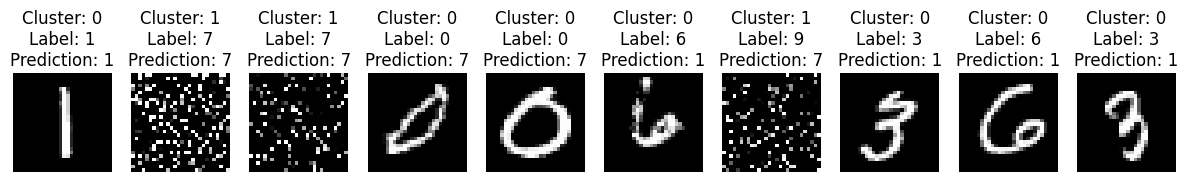

In [209]:
expert.eval()
expert.cpu()
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(test_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    image = image[np.newaxis, :]

    outputs = expert(image).argmax(dim=1)
    
    cluster_label = cluster_labels_test[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}\nPrediction: {outputs.item()}')
    plt.axis('off')
plt.show()

# Inference

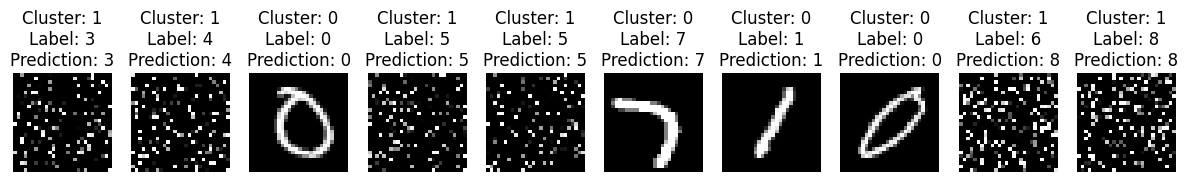

In [69]:
moe.eval()
moe.cpu()
permut = nas_moe.nni_utils.PixelPermutationLayer(permutation)
plt.figure(figsize=(15, 5))
num_images = 10
random_indices = np.random.choice(len(test_dataset), num_images, replace=False)
for i, idx in enumerate(random_indices):
    image, true_label = test_dataset[idx]
    image = image[np.newaxis, :]

    outputs = moe(image).argmax(dim=1)
    
    cluster_label = cluster_labels_test[idx]
    
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.squeeze(), cmap='gray')  # Подразумевается, что изображение grayscale
    plt.title(f'Cluster: {cluster_label}\nLabel: {true_label}\nPrediction: {outputs.item()}')
    plt.axis('off')
plt.show()